In [3]:
from experiments.cube.Cube import Cube
from hdimvis.metrics.stress.stress import vectorised_stress
from hdimvis.metrics.distance_measures.euclidian_and_manhattan import euclidean
from sklearn.decomposition import PCA
from hdimvis.algorithms.stochastic_ntet_algo.SNeD import SNeD
from hdimvis.create_low_d_layout.LowDLayoutCreation import LowDLayoutCreation
from hdimvis.data_fetchers.DataFetcher import DataFetcher
from hdimvis.visualise_layouts_and_metrics.plot import show_layouts, show_generation_metrics
from hdimvis.metrics.distance_measures.euclidian_and_manhattan import manhattan
import numpy as np
import matplotlib.pyplot as plt
import os
import definitions
from time import perf_counter
import pathlib
from pathlib import Path

In [2]:
all_datasets_list = ['poker', 'mnist', 'coil20', 'rna N3k', 'airfoil', 'wine quality', 'fashion mnist'
                                                                                                'shuttle',
                     'flow cytometry']


In [4]:
cube = Cube(num_points=100, side=30, angle=0.4)
cube_dataset= cube.get_sample_dataset(3000)

rna_dataset = DataFetcher.fetch_data('rna N3k')
coil20_dataset = DataFetcher.fetch_data('coil20')
airfoil_dataset = DataFetcher.fetch_data('airfoil')


####################
Fetching the "rna N3k" dataset
####################
Dataset loaded
Dataset shape: (3000, 50)
####################
Fetching the "coil20" dataset
####################
Dataset loaded
Dataset shape: (1440, 1024)
####################
Fetching the "airfoil" dataset
####################
Dataset loaded
Dataset shape: (1502, 5)


In [5]:
names_list = ['trio', 'quartet', 'quintet', 'sextet', 'septet', 'octet', 'nonet', 'decet',
               'duodecet', 'vigintet', 'quinquagintet', 'centet', 'duocentet', 'quingentet']
ntet_sizes = [100,200,500]
# 3,4,5,6,7,8,9,10,12,20,50,

In [6]:

num_repeats = 3
datasets = [rna_dataset, coil20_dataset]

results = np.zeros((num_repeats, 3)) # 4 for - time, stress, average quartet stress and ntet size



####################
A 2D layout of the "rna N3k" dataset will be created 
using the "Stochastic N-tet Descent MDS" algorithm
####################
The HD distance measure used is: euclidean
####################
####################
No metrics will be collected during layout creation. 
To change this use the 'metric collection' parameter of the layout 
####################
All stress calculations will be performed using the euclidian norm
####################
 "N-tet" size: 100

 Vectorised euclidean stress 

####################
A 2D layout of the "rna N3k" dataset will be created 
using the "Stochastic N-tet Descent MDS" algorithm
####################
The HD distance measure used is: euclidean
####################
####################
No metrics will be collected during layout creation. 
To change this use the 'metric collection' parameter of the layout 
####################
All stress calculations will be performed using the euclidian norm
####################
 "N-tet" size: 100

 Ve

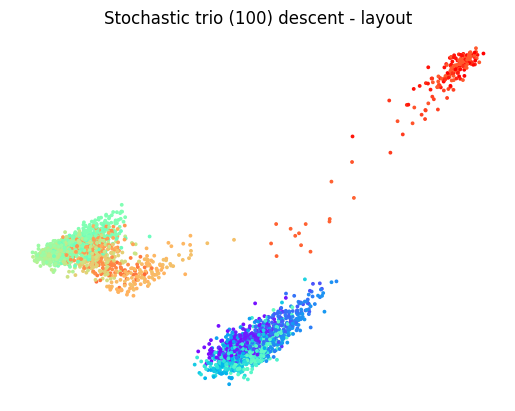

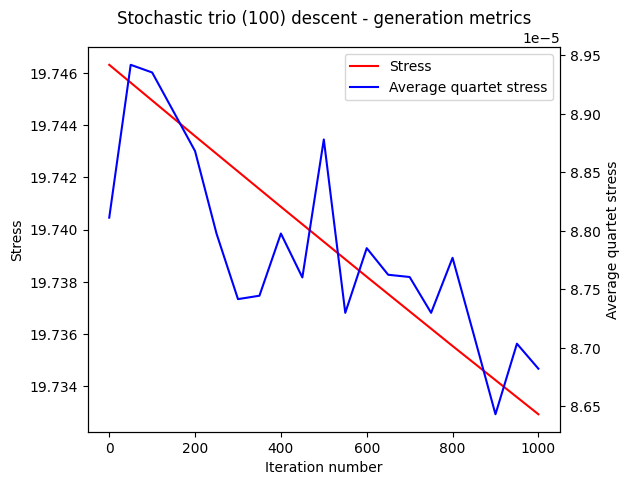

####################
A 2D layout of the "rna N3k" dataset will be created 
using the "Stochastic N-tet Descent MDS" algorithm
####################
The HD distance measure used is: euclidean
####################
####################
No metrics will be collected during layout creation. 
To change this use the 'metric collection' parameter of the layout 
####################
All stress calculations will be performed using the euclidian norm
####################
 "N-tet" size: 200


KeyboardInterrupt: 

In [8]:
metric_collection = {'Average quartet stress': 50, 'Stress': 200}

for i, dataset in enumerate(datasets):

    output_dir= (Path(definitions.PROJECT_ROOT).joinpath(
    Path(f"experiments/stochastic_ntet_descent/out/{dataset.name}/"))).resolve()
    # os.mkdir(output_dir)


    Xld = PCA(n_components=2, whiten=False, copy=True).fit_transform(dataset.data).astype(np.float64)
    Xld *= 10/np.std(Xld)

    if dataset==cube_dataset:
         cube.plot_2d(layout_points=Xld, hd_points=dataset.data, title="PCA layout", save_to=output_dir)


    for j, size in enumerate(ntet_sizes):
        time = 0
        stress = 0
        average_quartet_stress = 0

        Xld = PCA(n_components=2, whiten=False, copy=True).fit_transform(dataset.data).astype(np.float64)
        Xld *= 10/np.std(Xld)

        layout = None
        for k in range(num_repeats):

            squad = SNeD(dataset=datasets[i], initial_layout=Xld, ntet_size=size)

            # only collect stress and show generation metrics for the last repeat - shouldn't differ too much between repeats and, in any case, it is not the main focus of this experiment
            if k == num_repeats- 1:
                current_metric_collection = metric_collection
            else:
                current_metric_collection = None

            start = perf_counter()
            layout = LowDLayoutCreation().create_layout(squad, optional_metric_collection=current_metric_collection, no_iters=1000)

            time = (start - perf_counter())
            stress = layout.get_final_stress()

            results[k][0] = time
            results[k][1] = stress
            if k == num_repeats- 1:
                average_quartet_stress = layout.collected_metrics['Average quartet stress'][1][-1]
                results[k][2] = average_quartet_stress


        print(layout.collected_metrics)

        title = f"Stochastic {names_list[j]} ({size}) descent"

        if dataset == cube_dataset:
             cube.plot_2d(layout, title=title + " - layout", save_to=output_dir)
        else:
            show_layouts(layout, use_labels=True, color_map='rainbow', title=title + " - layout", save_to=output_dir)

        show_generation_metrics(layout, quartet_stress=True, title= title + " - generation metrics", save_to=output_dir)
        np.save((Path(output_dir).joinpath(Path(f"{title}"))).resolve(),results)
        results.fill(0)


